In [1]:
%config InlineBackend.figure_format = "svg"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection


In [3]:
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))
from IPython.display import display, HTML

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


In [4]:
R = 6.35 / 2
Rg = R * 1.08
dR = R * 0.08 / np.sqrt(2)
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dR, -dR],[-dR, dR]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dR, dR],[dR, -dR]]), R=np.array([Rg, Rg]))

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
n_slice = 21
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
SliceForceRatio = TB.SliceForceRatio(n_slice)
mu = 0.10


In [5]:
p0 = np.array([[4,0,0], [5,0,0]])
x0 = np.array([2,0,0])
v0 = np.array([0,0,100])
w0 = np.array([0,0,5])

TB.surface_velocity(x0, p0, v0, w0)


array([[  0,  10, 100],
       [  0,  15, 100]])

In [6]:
def vaT_ball(xvw_ball, t, R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I):
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    Zeros = np.zeros(3)
    F_sum = Zeros.copy()
    T_sum = Zeros.copy()
    vr = np.linalg.norm(v_ball)

    for iSP, SP in enumerate(SP12):
        for i in range(2):
            cos_sin1, dx1, exyz1 = SP.get_contact(x_ball, R, i)
            if dx1 > 0:
                SP_r_inv = SP.get_rho(cos_sin1[0], i)
                R_Reduced1 = 1.0 / (Ball_r_inv + SP_r_inv)
                k1, a1, b1 = TB.BrewHamrock(R_Reduced1[0], R_Reduced1[1], dx1, E_Reduced)
                v1 = v_ball.dot(exyz1)
                F1_norm = TB.Tsuji(k1, zeta, Ball_m, v1, dx1)
                F1 = - F1_norm * exyz1

                eta1 = SP.to_eta2(x_ball)
                xyz2eta1 = SP.get_xyz2eta(eta1[0])
                b_dir = xyz2eta1.T @ np.array([1.0, 0.0, 0.0])
                a_dir = np.cross(b_dir, exyz1)
                
                peak = x_ball + (R - dx1 / 2) * exyz1
                r_slice = (np.arange(n_slice) - n_slice / 2 + 0.5) / n_slice * 2
                a_slice = a1 * r_slice
                b_slice = b1 * r_slice
                p_slice = peak + a_slice.reshape(-1, 1) @ a_dir.reshape(1, -1) - 0.5 * np.square(a_slice).reshape(-1, 1) / R @ exyz1.reshape(1, -1)
                SP_v = TB.surface_velocity(Zeros, p_slice, v12[iSP], w12[iSP])
                BL_v = TB.surface_velocity(x_ball, p_slice, v_ball, w_ball)
                dv = BL_v - SP_v
                F_slice = F1_norm * SliceForceRatio
                v_dir = dv.T * (1 / np.sqrt(np.square(dv).sum(1)))
                muF = - F_slice * v_dir * mu
                muT = TB.calc_Torque(x_ball, p_slice, muF.T)
                F_sum = F_sum + F1 + muF.sum(1)
                T_sum = T_sum + muT.sum(0)
                
    a_ball = F_sum / Ball_m * 1e6
    T_ball = T_sum / Ball_I * 1e6
    
    return np.concatenate([v_ball, a_ball, T_ball])


In [7]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -10 * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


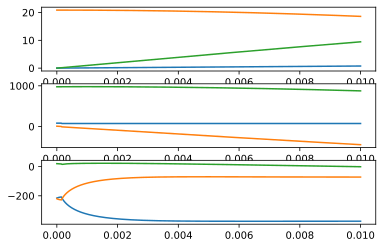

In [8]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()


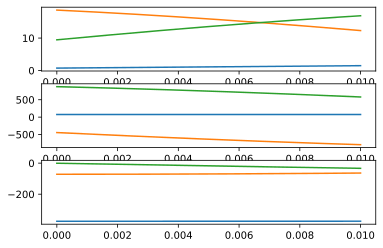

In [9]:
xvw_ball = sol[-1, :]

sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()

In [10]:
xvw_ball = sol[-1, :]
xvw_ball


array([   1.49884677,   12.30078432,   16.86784601,   74.88768067,
       -793.68695555,  578.79198955, -373.68038217,  -63.64343175,
        -33.30827251])

In [11]:
x_ball0 = xvw_ball[0:3]
v_ball0 = xvw_ball[3:6]
w_ball0 = xvw_ball[6:9]
eta1 = SP1.to_eta2(x_ball0)
th1 = eta1[0]

v_eta1 = SP1.get_xyz2eta(th1) @ v_ball0
v_eta1


array([ 9.85163598e+02, -1.59204494e-02, -5.71379538e-03])

In [12]:
w_eta1 = SP1.get_xyz2eta(th1) @ w_ball0

In [13]:
eta2 = SP2.to_eta2(x_ball0)
th2 = eta1[0]

v_eta2 = SP2.get_xyz2eta(th2) @ v_ball0
v_eta2


array([ 9.85157686e+02,  3.41299248e+00, -5.26306417e-03])

In [14]:
th1_new = 0.0
eta1_new = eta1.copy()
eta1_new[0] = th1_new

x_ball0_new = SP1.to_xyz(eta1_new)
v_ball0_new = SP1.get_xyz2eta(th1_new).T @ v_eta1
w_ball0_new = SP1.get_xyz2eta(th1_new).T @ w_eta1

xvw_ball0_new = np.concatenate([x_ball0_new, v_ball0_new, w_ball0_new])
xvw_ball0_new


array([ 4.40992309e-03,  2.08765950e+01,  3.61003476e-02,  7.48876807e+01,
       -1.69853860e+00,  9.82311695e+02, -3.73680382e+02, -6.44667767e+01,
        3.16853613e+01])

In [26]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -10 * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
xvw_ball

array([   0.        ,   20.875     ,    0.        ,   83.3333333 ,
          9.002899  ,  976.4002461 , -215.63089828, -219.90011693,
         20.43115173])

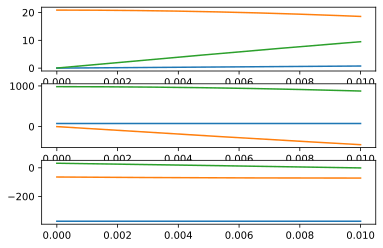

In [16]:
sol = odeint(vaT_ball, xvw_ball0_new, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()

In [17]:
x_ball = xvw_ball0_new[0:3]
v_ball = xvw_ball0_new[3:6]
w_ball = xvw_ball0_new[6:9]
Zeros = np.zeros(3)
F1 = np.zeros([2, 2, 3])
muF1 = F1.copy()
dx1_ = np.zeros([2, 2])
T1 = F1.copy()
dv1 = np.zeros([2, 2, 21, 3])

for iSP, SP in enumerate([SP1, SP2]):
    for i in range(2):
        cos_sin1, dx1, exyz1 = SP.get_contact(x_ball, R, i)
        dx1_[iSP, i] = dx1
        if dx1 > 0:
            SP_r_inv = SP.get_rho(cos_sin1[0], i)
            R_Reduced1 = 1.0 / (Ball_r_inv + SP_r_inv)
            k1, a1, b1 = TB.BrewHamrock(R_Reduced1[0], R_Reduced1[1], dx1, E_Reduced)
            v1 = v_ball.dot(exyz1)
            F1_norm = TB.Tsuji(k1, zeta, Ball_m, v1, dx1)
            F1[iSP, i, :] = - F1_norm * exyz1

            eta1 = SP.to_eta2(x_ball)
            xyz2eta1 = SP.get_xyz2eta(eta1[0])
            b_dir = xyz2eta1.T @ np.array([1.0, 0.0, 0.0])
            a_dir = np.cross(b_dir, exyz1)

            peak = x_ball + (R - dx1 / 2) * exyz1
            r_slice = (np.arange(n_slice) - n_slice / 2 + 0.5) / n_slice * 2
            a_slice = a1 * r_slice
            b_slice = b1 * r_slice
            p_slice = peak + a_slice.reshape(-1, 1) @ a_dir.reshape(1, -1) - 0.5 * np.square(a_slice).reshape(-1, 1) / R @ exyz1.reshape(1, -1)
            SP_v = TB.surface_velocity(Zeros, p_slice, v12[iSP], w12[iSP])
            BL_v = TB.surface_velocity(x_ball, p_slice, v_ball, w_ball)
            dv = BL_v - SP_v
            dv1[iSP, i, :, :] = dv
            F_slice = F1_norm * SliceForceRatio
            v_dir = dv.T * (1 / np.sqrt(np.square(dv).sum(1)))
            muF = - F_slice * v_dir * mu
            muT = TB.calc_Torque(x_ball, p_slice, muF.T)
            muF1[iSP, i, :] = muF.sum(1)
            T1[iSP, i, :] = muT.sum(0)


In [18]:
F1

array([[[-37.18947637,  36.06644281,   2.89834813],
        [  0.        ,   0.        ,   0.        ]],

       [[ 36.54553721, -36.75006702,  -2.84970465],
        [ -2.73274107,  -2.78314604,   0.20354828]]])

In [19]:
muF1

array([[[ 1.68767831,  1.73128271,  0.0703239 ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 1.7082411 ,  1.69611714,  0.06738617],
        [-0.01925058, -0.00957621, -0.38998535]]])

In [20]:
dx1_

array([[ 0.00201314, -0.00426944],
       [ 0.00193986,  0.00036766]])

In [21]:
F1.sum(0).sum(0) + muF1.sum(0).sum(0)

array([-1.13892848e-05, -4.89466137e-02, -8.35297091e-05])

In [22]:
T1.sum(0).sum(0)

array([ 2.3459466e-05, -6.3904561e-03, -1.2955037e-02])

In [24]:
dv1

array([[[[  -4.48801375,   -9.69283623,   90.12222056],
         [  -5.0443927 ,   -9.79514337,   81.51360238],
         [  -5.60948471,   -9.89608612,   72.77620634],
         [  -6.18328979,   -9.99566447,   63.91003244],
         [  -6.76580793,  -10.09387843,   54.91508068],
         [  -7.35703914,  -10.190728  ,   45.79135105],
         [  -7.95698341,  -10.28621318,   36.53884356],
         [  -8.56564074,  -10.38033396,   27.15755821],
         [  -9.18301114,  -10.47309035,   17.647495  ],
         [  -9.8090946 ,  -10.56448235,    8.00865393],
         [ -10.44389113,  -10.65450996,   -1.75896501],
         [ -11.08740072,  -10.74317317,  -11.65536181],
         [ -11.73962337,  -10.83047199,  -21.68053647],
         [ -12.40055909,  -10.91640642,  -31.83448899],
         [ -13.07020788,  -11.00097646,  -42.11721937],
         [ -13.74856972,  -11.0841821 ,  -52.52872762],
         [ -14.43564463,  -11.16602335,  -63.06901373],
         [ -15.13143261,  -11.24650021,  -73.738